**motivation**<br>
When I was competing in <a href="https://www.kaggle.com/c/instacart-market-basket-analysis">Kaggle's Instacart Market Basket Analysis</a>, I had a great experience using xgboost. The same features under xgboost got so much more mileage than logistic regression. This motivated me to learn more about gradient boosting, and I came across Ben Gorman's great <a href="http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/">tutorial</a>. In this notebook I'll try to replicate his results in Draft 3.

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.core.display import HTML
import os
import matplotlib.pyplot as plt

In [2]:
# data entry
age = np.array([13,14,15,25,35,49,68,71,73])
likes_gardening = np.array([0,0,0,1,0,1,1,1,1])
plays_videogames = np.array([1,1,1,1,1,0,1,0,0])
likes_hats = np.array([1,0,0,1,1,0,1,0,1])

df = pd.DataFrame()
df['age'] = age
df['likes_gardening'] = likes_gardening
df['plays_videogames'] = plays_videogames
df['likes_hats'] = likes_hats

In [3]:
# train a decision tree
X = df.drop(['age'], axis=1)
y = df['age']

regressor = DecisionTreeRegressor(random_state=0, max_depth=2)
regressor.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

In [4]:
# visualize the tree
home = os.getenv('HOME')
file = home + '/Machine_Learning_Examples/tree_1.dot'
export_graphviz(regressor, out_file=file, feature_names=['likes_gardening', 'plays_videogames', 'likes_hats'])
# run this line in terminal where tree_1.dot is saved: dot -Tpng tree_1.dot -o tree_1.png
# go to the folder to open the png file or display it in the next cell

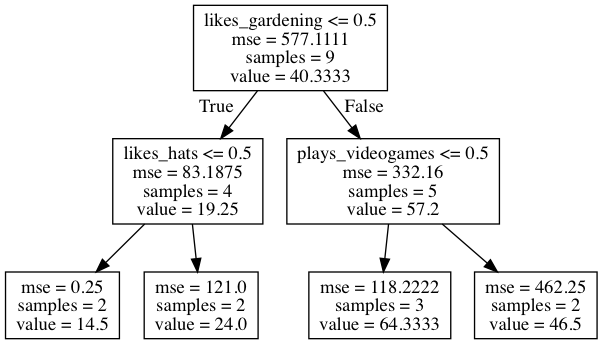

In [5]:
tree = home + '/Machine_Learning_Examples/tree_1.png'
Image(filename=tree)

**now replicate squared error under gradient boosting draft 3**

In [6]:
# for quadratic loss function the constant that minimizes cost among all constants is the mean:
df['F0'] = df['age'].mean()

# for quadratic loss function pseudo residual is just residual (differentiating the loss function w.r.t. the 
# prediction, then add a minus sign) 
df['PseudoResidual0'] = df['age'] - df['F0'] 

# now fit pseudo residuals
X = df[['likes_gardening', 'plays_videogames', 'likes_hats']]
y = df['PseudoResidual0']
regressor = DecisionTreeRegressor(random_state=0, max_depth=1)
regressor.fit(X, y)

# predicted pseudo residuals
df['h0'] = regressor.predict(X)

# update prediction using exisiting prediction and predicted pseudo residuals, assuming gamma = 1
# see below for why gamma = 1
df['F1'] = df['F0'] + df['h0']
df['PseudoResidual1'] = df['age'] - df['F1'] 

# do another round of fitting pseudo residuals
X = df[['likes_gardening', 'plays_videogames', 'likes_hats']]
y = df['PseudoResidual1']
regressor = DecisionTreeRegressor(random_state=0, max_depth=1)
regressor.fit(X, y)
df['h1'] = regressor.predict(X)
df['F2'] = df['F1'] + df['h1']

In [7]:
# this replicates the squared error case
df

,age,likes_gardening,plays_videogames,likes_hats,F0,PseudoResidual0,h0,F1,PseudoResidual1,h1,F2
0,13,0,1,1,40.333333,-27.333333,-21.083333,19.25,-6.25,-3.566667,15.683333
1,14,0,1,0,40.333333,-26.333333,-21.083333,19.25,-5.25,-3.566667,15.683333
2,15,0,1,0,40.333333,-25.333333,-21.083333,19.25,-4.25,-3.566667,15.683333
3,25,1,1,1,40.333333,-15.333333,16.866667,57.20,-32.20,-3.566667,53.633333
4,35,0,1,1,40.333333,-5.333333,-21.083333,19.25,15.75,-3.566667,15.683333
5,49,1,0,0,40.333333,8.666667,16.866667,57.20,-8.20,7.133333,64.333333
6,68,1,1,1,40.333333,27.666667,16.866667,57.20,10.80,-3.566667,53.633333
7,71,1,0,0,40.333333,30.666667,16.866667,57.20,13.80,7.133333,64.333333
8,73,1,0,1,40.333333,32.666667,16.866667,57.20,15.80,7.133333,64.333333


**discussion**<br>
Question: why boost off of gradients (pseudo residuals), why not residuals directly?<br> 
Answer: to be able to respond to incentives of different loss functions. If loss function is quadratic, focus on training examples where the residual is large; whereas if loss function is absolute value, give every training example equal attention.

1. loss function is sum of squared errors or sum of absolute errors
2. the initial prediction is the constant that minimizes loss among all constants
3. under the squared errors loss function, such constant is the mean of the actual y values; under the absolute errors loss function, such constant is the median of the actual y values 
4. once we have an initial prediction, we can calculate derivative of loss function w.r.t. initial prediction, which tells us in which direction we should adjust the prediction. Notice that for each training example there is a prediction. When we evaluate the derivative we are evaluating partial derivatives w.r.t. each prediction corresponding to each training example
5. Once we have the derivatives, we add a negative sign to get pseudo residuals. Why are pseudo residuals negative of the gradient? Because negative gradient is the direction of steepest descent, it is the direction we want our prediction to go in order to bring down the loss function
6. now that we have pseudo residuals, we fit a small tree to it, to generate predicted pseudo residuals.
7. now we are going in the direction of predicted pseudo residuals (notice we have to go in the same direction for all training examples in the same leaf of the tree in 6. we are not allowed to go in different directions for training examples in the same leaf because at test time, the only thing we go by is the features and the splits based off of them), how big a step do we take? This depends on which leaf we are at in the tree in 6. For a given leaf, we choose step size $\gamma$ so that the updated prediction $(last\:prediction) + \gamma (predicted\:pseudo\:residual)$ minimizes the loss function at the corresponding leaf.

**now replicate absolute error under gradient boosting draft 3**

In [8]:
# for absolute loss function the constant that minimizes cost among all constants is the median:
df['F0_abs'] = np.median(df['age'])

In [9]:
# when actual age < predicted age, loss is equal to predicted age - actual age, the derivative w.r.t. predicted age 
# is 1, negative derivative is therefore -1
df['PseudoResidual0_abs'] = 1
df.loc[df['age'] <= df['F0_abs'], 'PseudoResidual0_abs'] = -1

In [10]:
# fit pseudo residuals
X = df[['likes_gardening', 'plays_videogames', 'likes_hats']]
y = df['PseudoResidual0_abs']
regressor = DecisionTreeRegressor(random_state=0, max_depth=1)
regressor.fit(X, y)
df['h0_abs'] = regressor.predict(X)

In [11]:
# define these functions to manually find step size gamma that minimizes loss function at a given leaf
def f_1(gamma):
    '''
    leaf 1, squared error case
    returns value of loss as a function of gamma
    '''
    box = 40.33 + gamma*(-21.08)
    return (13-box)**2 + (14-box)**2 + (15-box)**2 + (35-box)**2

def f_2(gamma):
    '''
    leaf 2, squared error case
    returns value of loss as a function of gamma
    '''
    box = 40.33 + gamma*(16.87)
    return (25-box)**2 + (49-box)**2 + (68-box)**2 + (71-box)**2 + (73-box)**2

def g_1(gamma):
    '''
    leaf 1, absolute error case
    returns value of loss as a function of gamma
    '''
    box = 35 + gamma*(-1)
    return np.abs(13-box) + np.abs(14-box) + np.abs(15-box) + np.abs(35-box)

def g_2(gamma):
    '''
    leaf 2, absolute error case
    returns value of loss as a function of gamma
    '''
    box = 35 + gamma*(0.6)
    return np.abs(25-box) + np.abs(49-box) + np.abs(68-box) + np.abs(71-box) + np.abs(73-box)

In [12]:
# use g_1 and g_2 here will replicate gamma0 for the absolute error case
gamma = [0.1*x for x in range(700)]
F = [g_2(x) for x in gamma]

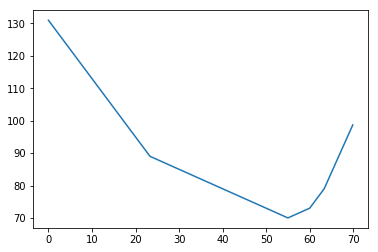

In [13]:
# this corresponds to gamma0 = 55 
plt.plot(gamma, F)
plt.show()

In [14]:
gamma = [0.1*x for x in range(100, 300)]
F = [g_1(x) for x in gamma]

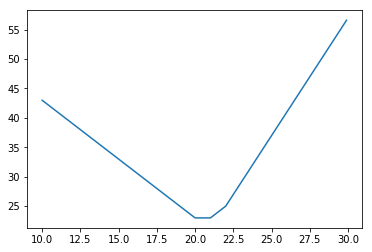

In [15]:
# this corresponds to gamma0 = 20.5
plt.plot(gamma, F)
plt.show()

In [16]:
# use f_1 and f_2 here will replicate gamma0 under squared error
gamma = [0.1*x for x in range(50)]
F = [f_2(x) for x in gamma]

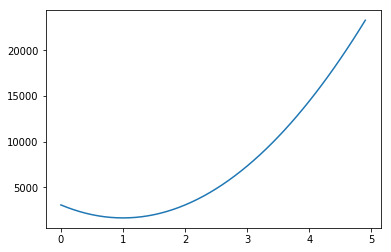

In [17]:
# this corresponds to gamma0 = 1
plt.plot(gamma, F)
plt.show()

In [18]:
gamma = [0.1*x for x in range(50)]
F = [f_1(x) for x in gamma]

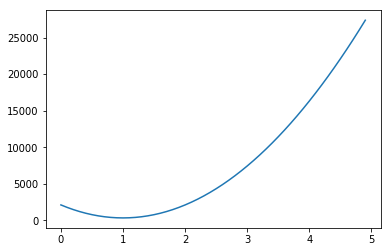

In [19]:
# this corresponds to gamma0 = 1
plt.plot(gamma, F)
plt.show()

I will not fully replicate the absolute error case, but it should be clear by now how to do it. The key is to fit pseudo residuals, or gradients of the loss function w.r.t. predictions. Notice that at test time residuals are no longer available, but we can still use these little trees to make predictions. For example, under the squared error scenario, when we have a new person who doesn't like gardening but plays video games, to predict this person's age we would use 40.33 as an initial guess, then update the guess to 19.25 because the person doesn't like gardening, then further update the guess to 15.68 because the person plays video games. So the prediction would be 15.68. 

**more references: <br>**
https://sadanand-singh.github.io/posts/boostedtrees/ <br>
https://en.wikipedia.org/wiki/Line_search <br>